In [40]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [41]:
# I got error on downloading this dataset so I only use it online without downloading

#transform data into Tensor and normalize with mean = 0.5, standard deviation = 0.5 -> do lech chuan
transform = transforms.Compose([
    transforms.ToTensor() ,
    transforms.Normalize((0.5, 0.5 , 0.5),(0.5, 0.5 , 0.5)),
])


training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transform
)

training_data , valid_data = torch.utils.data.random_split(training_data , [0.9, 0.1])


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform= transform
)

#after transform image become tensor and can only displayed using plt.imshow with img.squeeze()

Files already downloaded and verified
Files already downloaded and verified


In [42]:
from torch.utils.data import DataLoader


epoch_num = 3
batch_size_train = 64
batch_size_test = 1000
l_r = 0.01
momentum = 0.9
log_interval = 100  #how often the training result being printed (1 time for every 100 batches)

random_seed = 10
torch.manual_seed(random_seed)


In [43]:
# for shuffling the dataset when we sample a minibatch in the training phase 

train_dataloader = DataLoader(training_data , batch_size = batch_size_train , shuffle= True)
valid_dataloader = DataLoader(valid_data , batch_size = batch_size_test, shuffle= False)

test_dataloader = DataLoader(test_data , batch_size= batch_size_test, shuffle = False )
data_loader = {'train' : train_dataloader , 'test':test_dataloader , 'valid':valid_dataloader}

In [44]:
import numpy as np 

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.099999994..0.9].


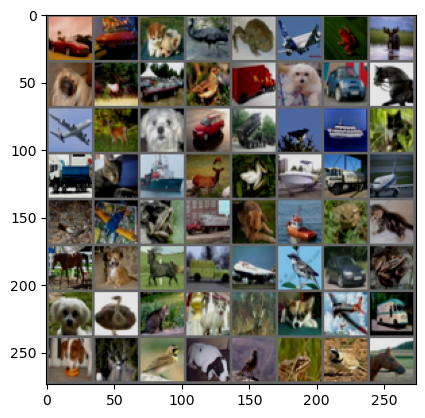

In [46]:
# to see a batch when DataLoader sampling, using next(iter(...)) #a batch is 64 figures size 1x28x28 and it's labels
train_features, train_labels = next(iter(train_dataloader))


#imshow redefinited function to display image using plt.imshow
def imshow(img):
    img = img/2 + 0.4
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_features))


In [47]:
def train_model(model , criterion , optimizer , scheduler ,best_model_params_path, num_epochs = 25):    
    since = time.time()
    best_acc = 0
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    for epoch in range(num_epochs):

        for phase in ['train' , 'valid']:
            running_loss = 0.0
            correct = 0 
            total = 0
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _ , prediction = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                total += labels.size(0)
                running_loss += loss.item()
                correct += torch.sum(prediction == labels.data)

            if phase == 'train':
                scheduler.step()
            epoch_loss = (running_loss)/total
            epoch_acc = correct / total 

            if phase == 'valid' and epoch_acc > best_acc:
                torch.save(model.state_dict(), best_model_params_path)
                best_acc = epoch_acc
        # print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {running_loss / len(train_dataloader)}, t loss: {}')

            if phase == 'train':
                print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {epoch_loss}')
            else:
                print(f' valid correct percent : {epoch_acc:.2f}')
        
                

    time_last = time.time() - since
    print(f'Training complete in {time_last // 60:.0f}m {time_last % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


                



                

        # for inputs, labels in train_dataloader:
        #     inputs, labels = inputs.to(device), labels.to(device)
            
        #     optimizer.zero_grad()
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        #     loss.backward()
        #     optimizer.step()
            
        #     running_loss += loss.item()
        

        
        # print(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {running_loss / len(train_dataloader)}, testing loss: {}')

    # print('Finished Training')

In [48]:
# model_list = [model = models.vgg16(weights= 'IMAGENET1K_V1'), models.resnet50(weights= 'IMAGENET1K_V1') , models.resnet101(weights= 'IMAGENET1K_V11') ,  models.densenet121(weights= 'IMAGENET1K_V1')]
# for model in model_list:
model = models.resnet50(weights= 'IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [49]:
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
# model = train_model(model , criterion , optimizer, 25 )
# model = train_model(model = models.vgg16(weights= 'IMAGENET1K_V1'), criterion = criterion  , optimizer = optimizer,scheduler= exp_lr_scheduler ,best_model_params_path='cifar_vgg16_best.pth', num_epochs= 15)
model = train_model(model = model, criterion = criterion  , optimizer = optimizer,scheduler= exp_lr_scheduler ,best_model_params_path='cifar_resnet50_best.pth', num_epochs= 15)
# model = train_model(model = models.resnet101(weights= 'IMAGENET1K_V11'), criterion = criterion  , optimizer = optimizer,scheduler= exp_lr_scheduler ,best_model_params_path='cifar_resnet101_best.pth', num_epochs= 15)
# model = train_model(model = models.densenet121(weights= 'IMAGENET1K_V1'), criterion = criterion  , optimizer = optimizer,scheduler= exp_lr_scheduler ,best_model_params_path='cifar_vgg16_best.pth', num_epochs= 15)


Epoch [1/15], training loss: 0.01586508295271132
 valid correct percent : 0.75
Epoch [2/15], training loss: 0.009858504925171534
 valid correct percent : 0.81
Epoch [3/15], training loss: 0.007665699685613314
 valid correct percent : 0.75
Epoch [4/15], training loss: 0.0059234516428576574
 valid correct percent : 0.81
Epoch [5/15], training loss: 0.004482379418777095
 valid correct percent : 0.77
Epoch [6/15], training loss: 0.004678445378773742
 valid correct percent : 0.82
Epoch [7/15], training loss: 0.0027325977213680745
 valid correct percent : 0.83
Epoch [8/15], training loss: 0.0010271907727337547
 valid correct percent : 0.86
Epoch [9/15], training loss: 0.00047181376840194897
 valid correct percent : 0.85
Epoch [10/15], training loss: 0.00032004413412521697
 valid correct percent : 0.86
Epoch [11/15], training loss: 0.00022493085240065638
 valid correct percent : 0.86
Epoch [12/15], training loss: 0.0001837849374058553
 valid correct percent : 0.86
Epoch [13/15], training loss

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('./cifar_resnet50_best.pth', weights_only=True))
model.to(device)
model.eval() #use evaluation mode in order to stop using drop out
correct = 0
total = 0
with torch.no_grad(): #disable gradient calculating to saving memory
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #send to device to use cpu or gpu 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #Gets the predicted class by finding the index of the maximum value in the output tensor along dimension 1
        total += labels.size(0)
        for i in predicted:
            if predicted[i] == labels[i]:
                correct+=1
        
print(f'Accuracy of the ResNet50 on the 10000 test images: {100 * correct / total}%')

Accuracy of the ResNet50 on the 10000 test images: 80.89%
